In [1]:
using CairoMakie
using JLD2
using FourierFlows
using Printf
include("ExactRadialSpectrum.jl")
include("RSWAnalysisSuite.jl")

plot_radial_energetics (generic function with 1 method)

In [2]:
function extract_run_directory(run_file, idx)
    for line=readlines(run_file)
        if parse(Int, split(line, " ")[1]) == idx
            return split(line, " ")[2]
        end
    end
    return ""
end

extract_run_directory (generic function with 1 method)

In [60]:
function create_total_plot(run_directories, labels, base_directory, fig_opts)
    grid = create_grid(base_directory)
    data_file = jldopen(@sprintf("%s/plot_data.jld2", base_directory), "r")

    f0, Cg2 = read_rsw_params(base_directory)
    params = (; f0, Cg2)
    Kd = f0/sqrt(Cg2)
    radii, weight_matrix = create_radialspectrum_weights(grid, 3);
    max_E = maximum(data_file["energy/series/KE/total"]) + maximum(data_file["energy/series/APE/total"])

    ave_ke_energy_fig = Figure(; fig_opts...)
    ic_ke_energy_fig  = Figure(; fig_opts...)
    fin_ke_energy_fig = Figure(; fig_opts...)
    
    ave_e_energy_fig = Figure(; fig_opts...)
    ic_e_energy_fig  = Figure(; fig_opts...)
    fin_e_energy_fig = Figure(; fig_opts...)

    ytickvals=10. .^ (-10:2)
    yticklabels = [rich("10", superscript(@sprintf("%d", value))) for value=-10:2]
    yminorticks = 10. .^ ((-12:2) .+ 0.5)
    xminorticks = 10. .^ (0.25:0.25:3)
    ax_opts = (; xscale=log10, yscale=log10, 
        xlabel="K/Kd", xticks=[1, 10, 100, 1000], 
        yticks=(ytickvals, yticklabels),
        xminorticks,
        xminorgridvisible=true,
        yminorticks,
        yminorgridvisible=true,
        limits=((3 * radii[1]/Kd, radii[end]/Kd), (1e-8 * max_E, 10 * max_E)))
    
    ave_ke_energy_ax = Axis(ave_ke_energy_fig[1,1]; title="Time-averaged radial Wave Kinetic Energy", ax_opts...)
     ic_ke_energy_ax = Axis( ic_ke_energy_fig[1,1]; title="Initial radial Wave Kinetic Energy", ax_opts...)
    fin_ke_energy_ax = Axis(fin_ke_energy_fig[1,1]; title="Final radial Wave Kinetic Energy", ax_opts...)
    
    ave_e_energy_ax = Axis(ave_e_energy_fig[1,1]; title="Time-averaged radial Wave Energy", ax_opts...)
     ic_e_energy_ax = Axis( ic_e_energy_fig[1,1]; title="Initial radial Wave Energy", ax_opts...)
    fin_e_energy_ax = Axis(fin_e_energy_fig[1,1]; title="Final radial Wave Energy", ax_opts...)

    Ew = nothing
    KEw = nothing
    for idx=1:length(directories)
        Ew, KEw = plot_radial_energetics(directories[idx], labels[idx], idx,
            ic_ke_energy_ax, ave_ke_energy_ax, fin_ke_energy_ax, 
            ic_e_energy_ax, ave_e_energy_ax, fin_e_energy_ax, grid)
    end
    axislegend(ave_ke_energy_ax, "Fr"; position=:lb, orientation=:vertical, nbanks=2)
    axislegend( ic_ke_energy_ax, "Fr"; position=:lb, orientation=:vertical, nbanks=2)
    axislegend(fin_ke_energy_ax, "Fr"; position=:lb, orientation=:vertical, nbanks=2)
    axislegend(ave_e_energy_ax,  "Fr"; position=:lb, orientation=:vertical, nbanks=2)
    axislegend( ic_e_energy_ax,  "Fr"; position=:lb, orientation=:vertical, nbanks=2)
    axislegend(fin_e_energy_ax,  "Fr"; position=:lb, orientation=:vertical, nbanks=2)

    
    crossing_point = 18/Kd
    start_point = 10/Kd
    end_point = 300/Kd
    k_max = grid.kr[end] * (1 - 1/3)
    vline_opts = (; color=:dimgray, linewidth=1, label=rich("k", subscript("max, eff")))
    for pair=[(ic_e_energy_fig,  ic_e_energy_ax,   nothing), 
             (ic_ke_energy_fig,  ic_ke_energy_ax,  nothing), 
             (ave_e_energy_fig,  ave_e_energy_ax,  Ew), 
             (ave_ke_energy_fig, ave_ke_energy_ax, KEw), 
             (fin_e_energy_fig,  fin_e_energy_ax, Ew), 
             (fin_ke_energy_fig, fin_ke_energy_ax, KEw)]
        energy_fig = pair[1]
        energy_ax = pair[2]
        field = pair[3]
        vl = vlines!(energy_ax,  [k_max/Kd]; vline_opts...)
        if ~isnothing(field)
            li1 = plot_radial_power_law(energy_ax, radii/Kd, weight_matrix, field, crossing_point, -2.00, start_point, end_point; linewidth=2, linestyle=:dash, color=:lightgray, label="-2 power law")
            li2 = plot_radial_power_law(energy_ax, radii/Kd, weight_matrix, field, crossing_point, -2.50, start_point, end_point; linewidth=2, linestyle=:dash, color=:gray, label="-2.5 power law")
            li3 = plot_radial_power_law(energy_ax, radii/Kd, weight_matrix, field, crossing_point, -3.00, start_point, end_point; linewidth=2, linestyle=:dash, color=:black, label="-3 power law")
            Legend(energy_fig[2, 1], 
                [li1, li2, li3, vl], 
                [rich("k", superscript("-2")), rich("k", superscript("-2.5")), rich("k", superscript("-3")), rich("k", subscript("max, eff"))];
                orientation=:horizontal)
        else
            Legend(energy_fig[2, 1], [vl], [rich("k", subscript("max, eff"))]; orientation=:horizontal)
        end
        colsize!(energy_fig.layout, 1, Relative(1.0))
    end
    
    return ic_ke_energy_fig, ave_ke_energy_fig, fin_ke_energy_fig, ic_e_energy_fig, ave_e_energy_fig, fin_e_energy_fig
end

function plot_radial_energetics(run_directory, label, idx, ic_ke_ax, ave_ke_ax, fin_ke_ax, ic_e_ax, ave_e_ax, fin_e_ax, grid)
    Nsnapshots = count_key_snapshots(run_directory, "rsw")
    
    _, ic_rsw = load_key_snapshot(run_directory, "rsw", 1)
    _, fin_rsw = load_key_snapshot(run_directory, "rsw", Nsnapshots)
    
    dealias!(ic_rsw, grid)
    dealias!(fin_rsw, grid)
    
    f0, Cg2 = read_rsw_params(run_directory)
    params = (; f=f0, Cg2)
    Kd = f0/sqrt(Cg2)
    bases = compute_balanced_wave_bases(grid, params)
    ((ic_KE, ic_PE, ic_KEg, ic_PEg, ic_KEw, ic_PEw, ic_Eg, ic_Ew, Z), _) = compute_energy(ic_rsw, bases, grid, params)
    ((fin_KE, fin_PE, fin_KEg, fin_PEg, fin_KEw, fin_PEw, fin_Eg, fin_Ew, Z), _) = compute_energy(fin_rsw, bases, grid, params)
    
    radii, weight_matrix = create_radialspectrum_weights(grid, 3);

    data_file = jldopen(@sprintf("%s/plot_data.jld2", run_directory), "r")
    Nsnapshots = length(data_file["energy/t"])
    Ew = data_file["energy/E/wave"]   / Nsnapshots
    KEw = data_file["energy/KE/wave"]  / Nsnapshots

    line_opts = (; label=label, linewidth=2, color=idx, colormap = :seaborn_colorblind, colorrange = (1, 10))

    plot_radial_energies(ic_ke_ax, ave_ke_ax, fin_ke_ax, radii, weight_matrix, Kd, ic_KEw, KEw, fin_KEw, line_opts)
    plot_radial_energies( ic_e_ax,   ave_e_ax,  fin_e_ax, radii, weight_matrix, Kd,  ic_Ew, Ew,  fin_Ew, line_opts)
    return Ew, KEw
end

function plot_radial_energies(ic_ax, ave_ax, fin_ax, radii, weight_matrix, Kd, ic_Ew, ave_Ew, fin_Ew, line_opts)
    plot_radial_data(ave_ax, radii/Kd, weight_matrix, ave_Ew; line_opts...)
    plot_radial_data( ic_ax, radii/Kd, weight_matrix,  ic_Ew; line_opts...)
    plot_radial_data(fin_ax, radii/Kd, weight_matrix, fin_Ew; line_opts...)
end

function extract_from_config_table(config_filepath, key, run_idx)
    config_file = open(config_filepath, "r")
    header = readline(config_file)
    col_idx = findfirst(item -> cmp(item, key) == 0, split(header, " "))
    for line=readlines(config_file)
        entries = split(line, " ")
        if parse(Int, entries[1]) == run_idx
            close(config_file)
            return parse(Float64, entries[col_idx])
        end
    end
    close(config_file)
    return -1
end

function plot_radial_power_law(ax, radii, weight_matrix, spectral_field, crossing_value, power, start_radius, end_radius; plot_options...)
    spectrum = radialspectrum(spectral_field, weight_matrix)
    spectrum = replace(spectrum, 0.0=>eps(0.0))
    radii_idx = findfirst(radius -> radius >= crossing_value, radii)
    spectral_value = spectrum[radii_idx]

    dx = (end_radius - start_radius)/100
    k_vals = start_radius:dx:end_radius
    spectral_vals = spectral_value * k_vals.^(power) / (crossing_value)^power
    return lines!(ax, k_vals, spectral_vals; plot_options...)
end

plot_radial_power_law (generic function with 1 method)

In [82]:
using FourierFlows

run_range = 42:49
config_file = "/vast/nad9961/rsw/65276574/1/froude-parameters.txt"
directories = Array{String}(undef, length(run_range))
labels = Array{String}(undef, length(run_range))

dir_idx = 1
for i=run_range
    base_directory = extract_run_directory("rsw-runs.txt", i)
    
    directories[dir_idx] = base_directory
    grid = create_grid(base_directory)
    
    f0, Cg2 = read_rsw_params(base_directory)
    params = (; f=f0, Cg2)
    Kd = f0/sqrt(Cg2)

    plot_data_file = jldopen(@sprintf("%splot_data.jld2", base_directory), "r")
    println(@sprintf("Fr:       %0.4f", maximum(plot_data_file["computed/Fr/geo"])))
    t0, initial_snapshot = load_key_snapshot(directories[dir_idx], "rsw", 2)
    uh = @views initial_snapshot[:,:,1]
    vh = @views initial_snapshot[:,:,2]
    ηh = @views initial_snapshot[:,:,3]
    ((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(uh, vh, ηh, grid, params)
    ug = irfft(ugh, grid.nx)
    vg = irfft(vgh, grid.nx)
    println(@sprintf("mean |u|: %0.4f", mean(sqrt.(ug.^2 + vg.^2))))
    println(@sprintf("<u>:      %0.4f", sqrt.(sum((ug.^2 + vg.^2))/grid.nx/grid.ny)))
    println()
    #println(sqrt(mean(ug.^2 + vg.^2)))
    #println(FourierFlows.parsevalsum2(ugh, grid) + FourierFlows.parsevalsum2(vgh, grid))
    labels[dir_idx] = @sprintf("%0.3f", mean(plot_data_file["computed/rms_u/geo"]))
    close(plot_data_file)
    dir_idx += 1
end

#fig_opts = (; size=(1200, 800), fontsize=32, fonts = (; regular = "Dejavu"))
#ic_ke_energy_fig, ave_ke_energy_fig, fin_ke_energy_fig, ic_e_energy_fig, ave_e_energy_fig, fin_e_energy_fig = create_total_plot(directories, labels, directories[end], fig_opts)

Fr:       0.0000
mean |u|: 0.0000
<u>:      0.0000

Fr:       0.0072
mean |u|: 0.0060
<u>:      0.0070

Fr:       0.0141
mean |u|: 0.0115
<u>:      0.0139

Fr:       0.0308
mean |u|: 0.0222
<u>:      0.0299

Fr:       0.0723
mean |u|: 0.0474
<u>:      0.0695

Fr:       0.1201
mean |u|: 0.0732
<u>:      0.1166

Fr:       0.1603
mean |u|: 0.0912
<u>:      0.1568

Fr:       0.1516
mean |u|: 0.0775
<u>:      0.1458



In [187]:
run_range = 42:49
config_file = "/vast/nad9961/rsw/65276574/1/froude-parameters.txt"
directories = Array{String}(undef, length(run_range))
labels = Array{String}(undef, length(run_range))

dir_idx = 1
for i=run_range
    directories[dir_idx] = extract_run_directory("rsw-runs.txt", i)
    labels[dir_idx] = @sprintf("%0.2f", (extract_from_config_table(config_file, "ag", dir_idx)))
    dir_idx += 1
end

fig_opts = (; size=(1200, 800), fontsize=32, fonts = (; regular = "Dejavu"))
ic_ke_energy_fig, ave_ke_energy_fig, fin_ke_energy_fig, ic_e_energy_fig, ave_e_energy_fig, fin_e_energy_fig = create_total_plot(directories, labels, directories[end], fig_opts)

(Scene (1200px, 800px):
  0 Plots
  3 Child Scenes:
    ├ Scene (1200px, 800px)
    ├ Scene (1200px, 800px)
    └ Scene (1200px, 800px), Scene (1200px, 800px):
  0 Plots
  3 Child Scenes:
    ├ Scene (1200px, 800px)
    ├ Scene (1200px, 800px)
    └ Scene (1200px, 800px), Scene (1200px, 800px):
  0 Plots
  3 Child Scenes:
    ├ Scene (1200px, 800px)
    ├ Scene (1200px, 800px)
    └ Scene (1200px, 800px), Scene (1200px, 800px):
  0 Plots
  3 Child Scenes:
    ├ Scene (1200px, 800px)
    ├ Scene (1200px, 800px)
    └ Scene (1200px, 800px), Scene (1200px, 800px):
  0 Plots
  3 Child Scenes:
    ├ Scene (1200px, 800px)
    ├ Scene (1200px, 800px)
    └ Scene (1200px, 800px), Scene (1200px, 800px):
  0 Plots
  3 Child Scenes:
    ├ Scene (1200px, 800px)
    ├ Scene (1200px, 800px)
    └ Scene (1200px, 800px))

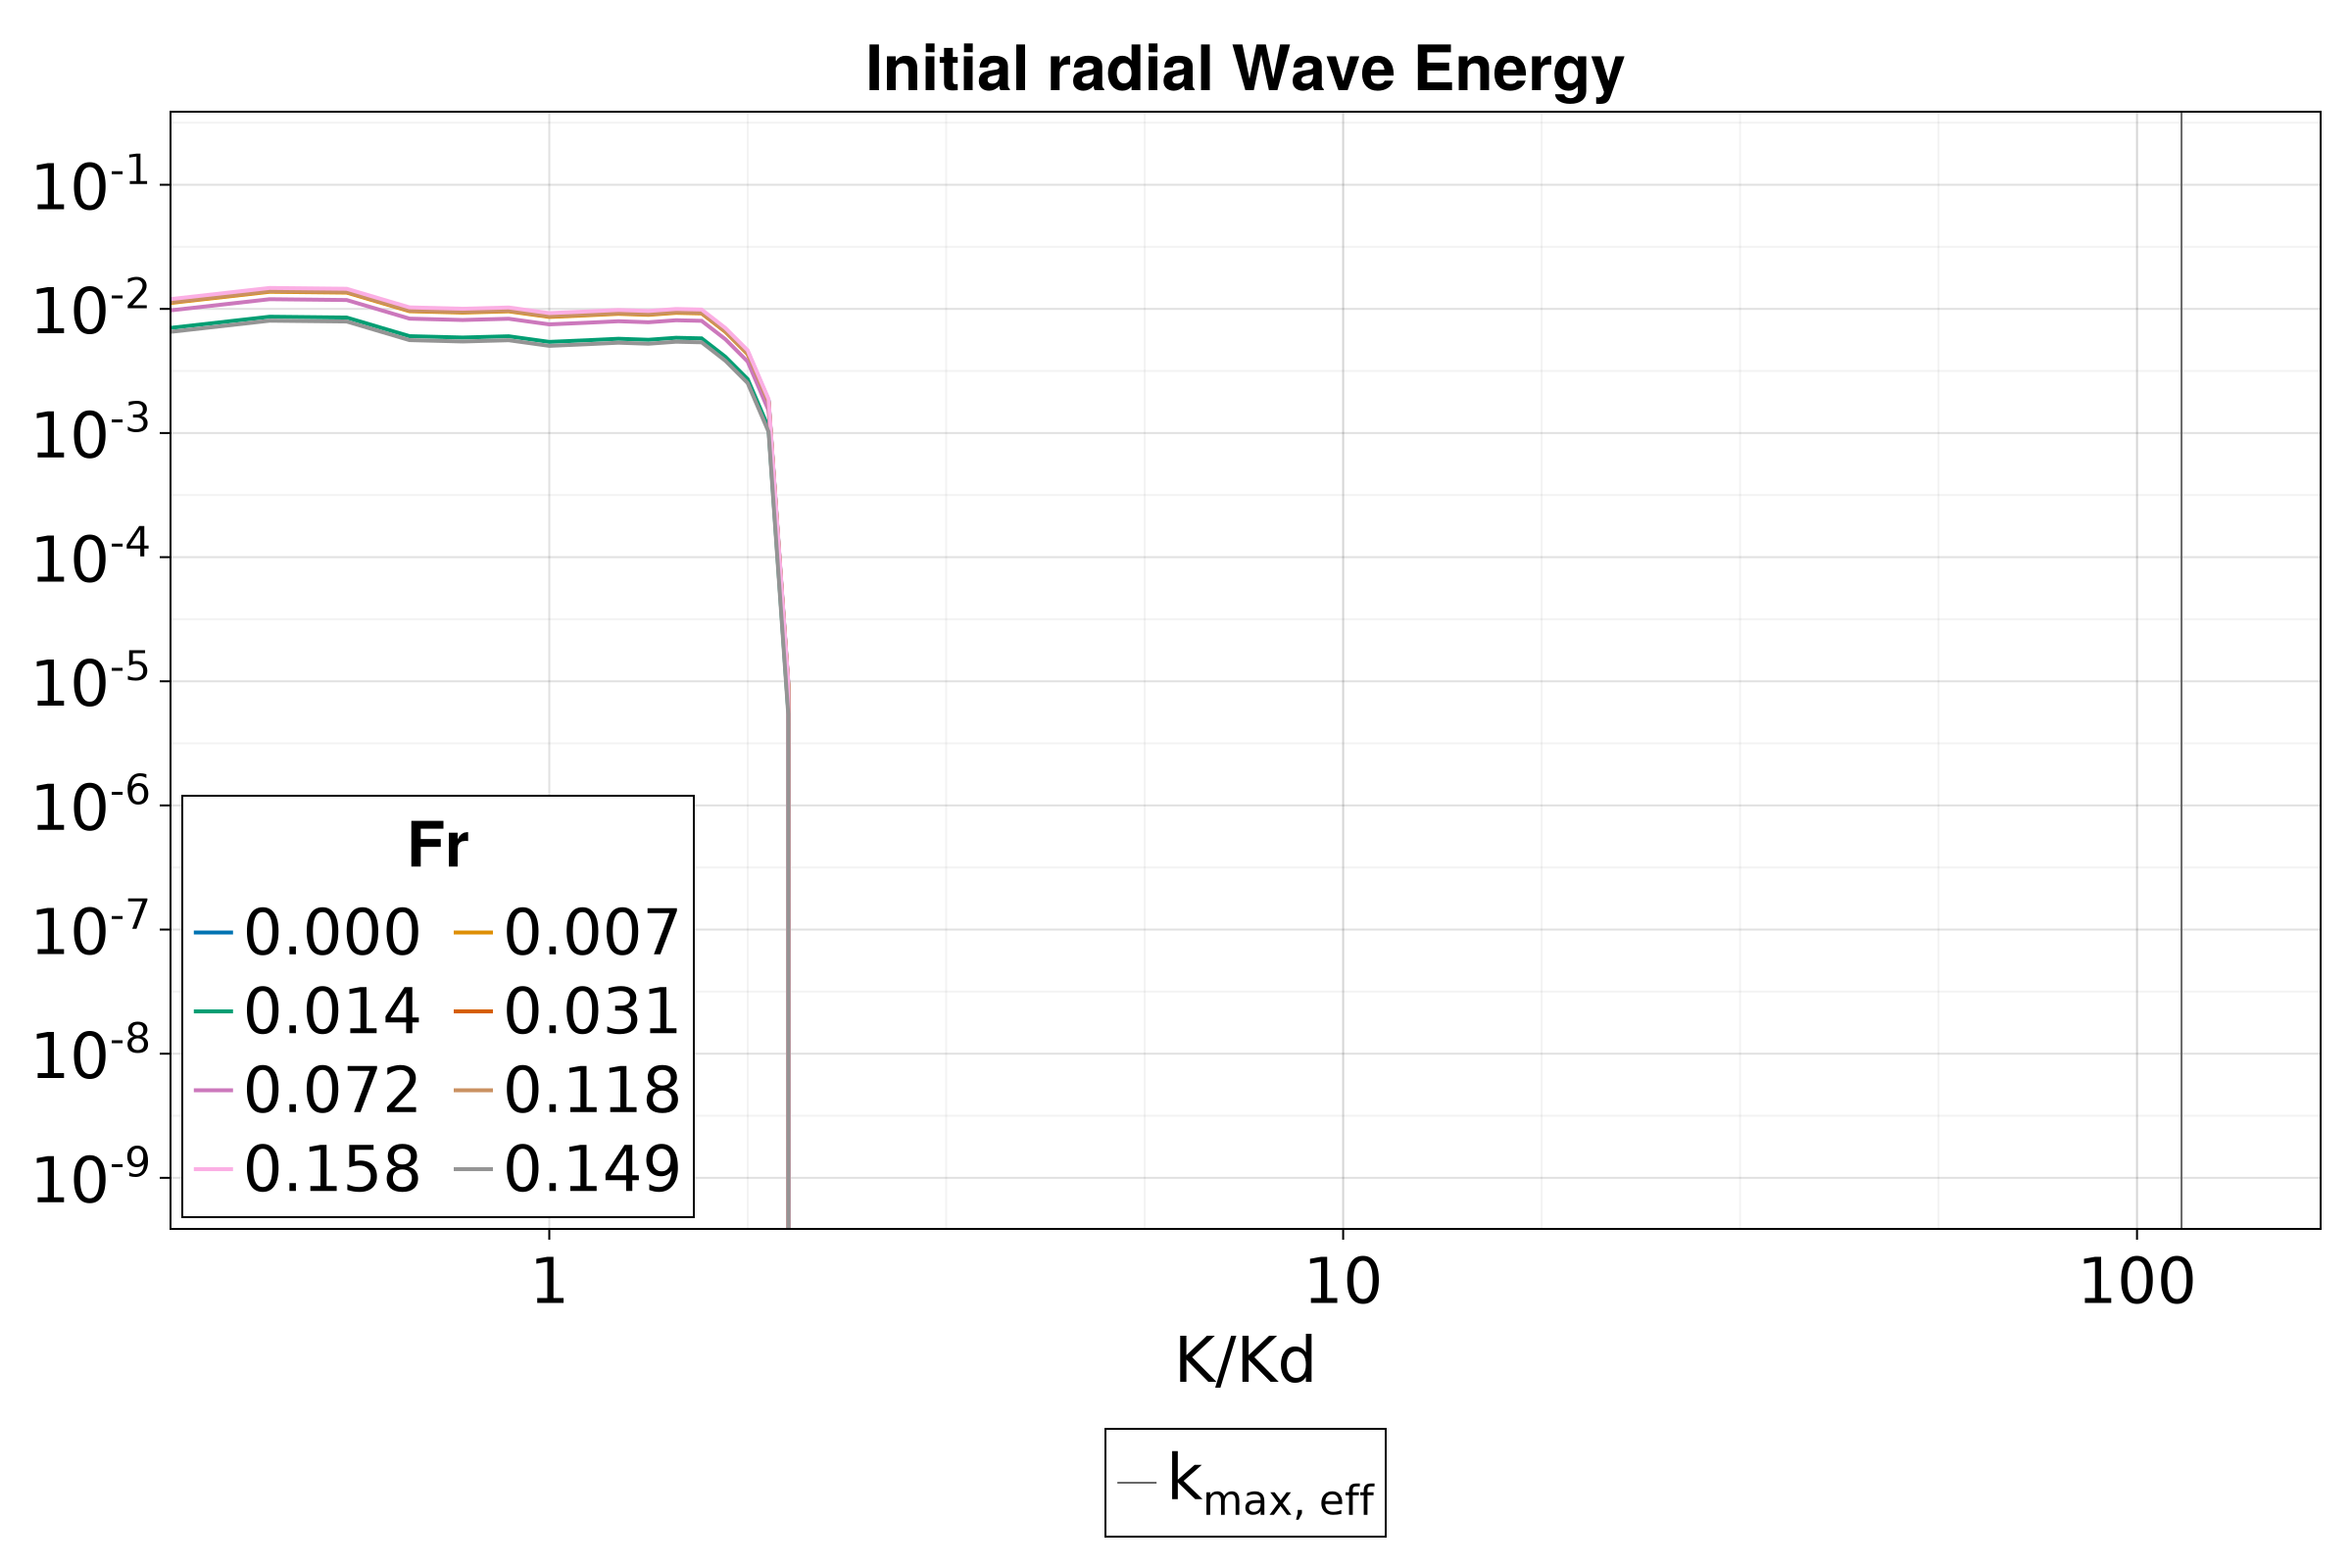

In [62]:
save("test_images/initial_wave_energy.png", ic_e_energy_fig)
ic_e_energy_fig

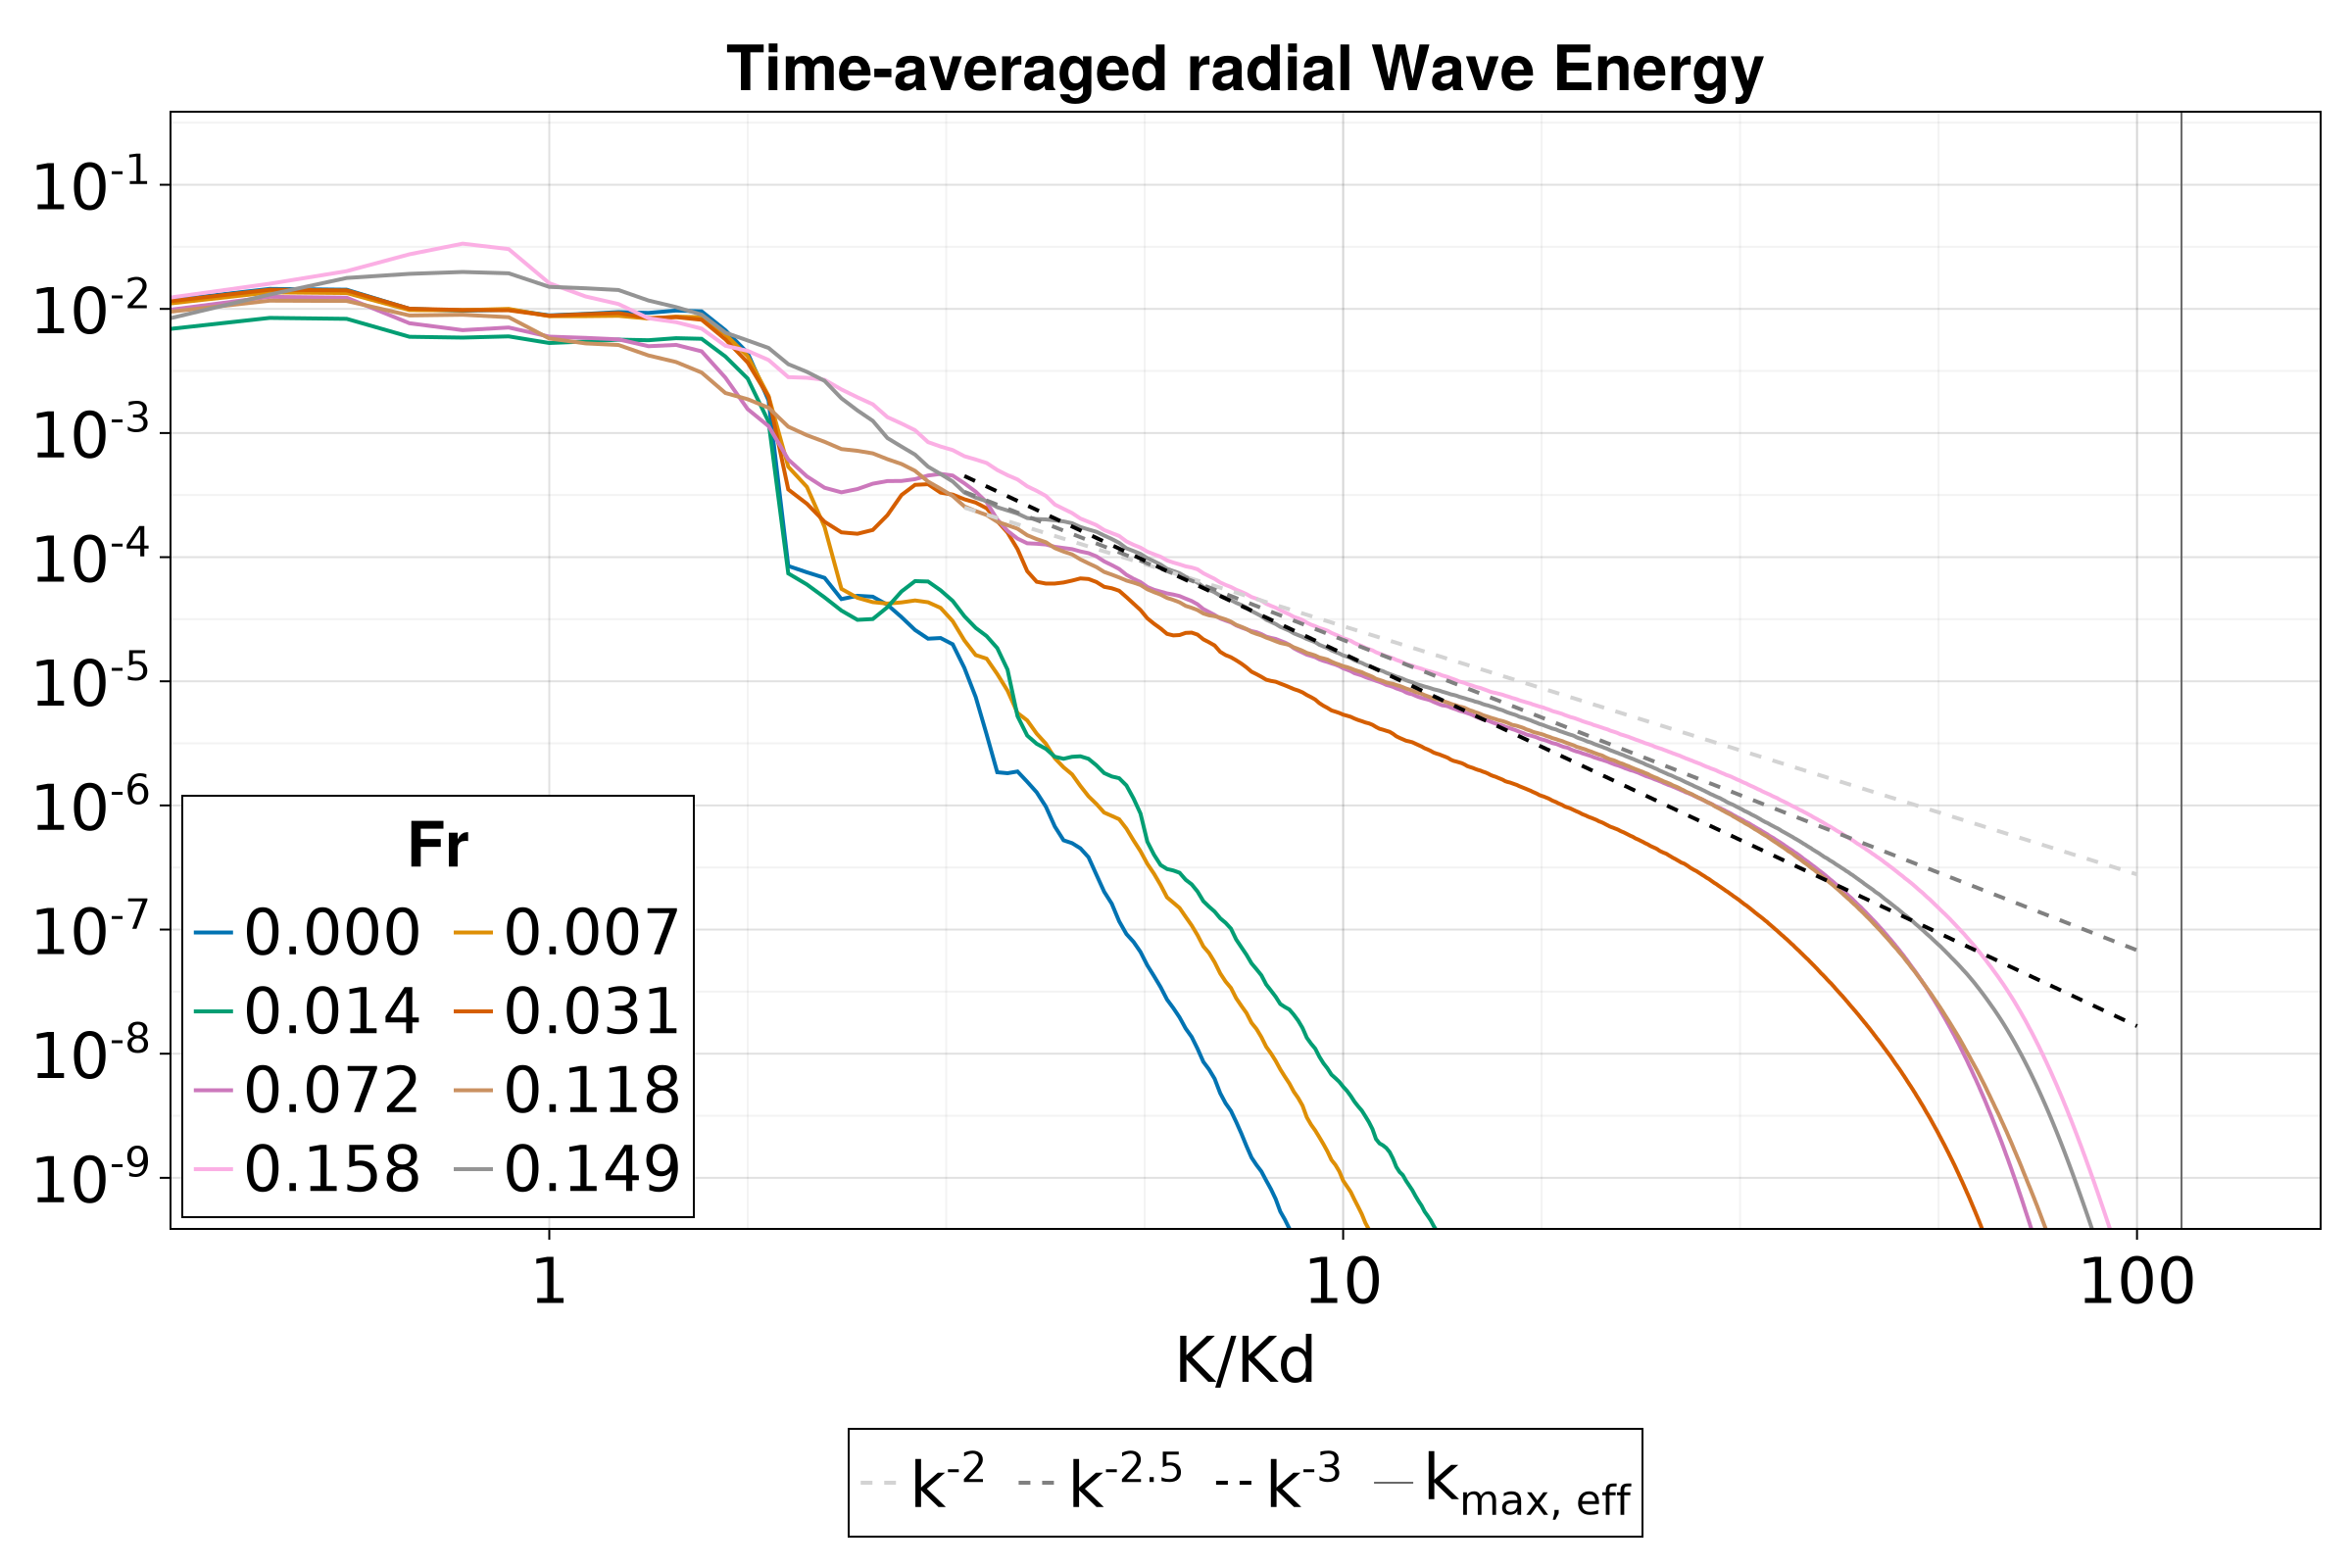

In [63]:
save("test_images/average_wave_energy.png", ave_e_energy_fig)
ave_e_energy_fig

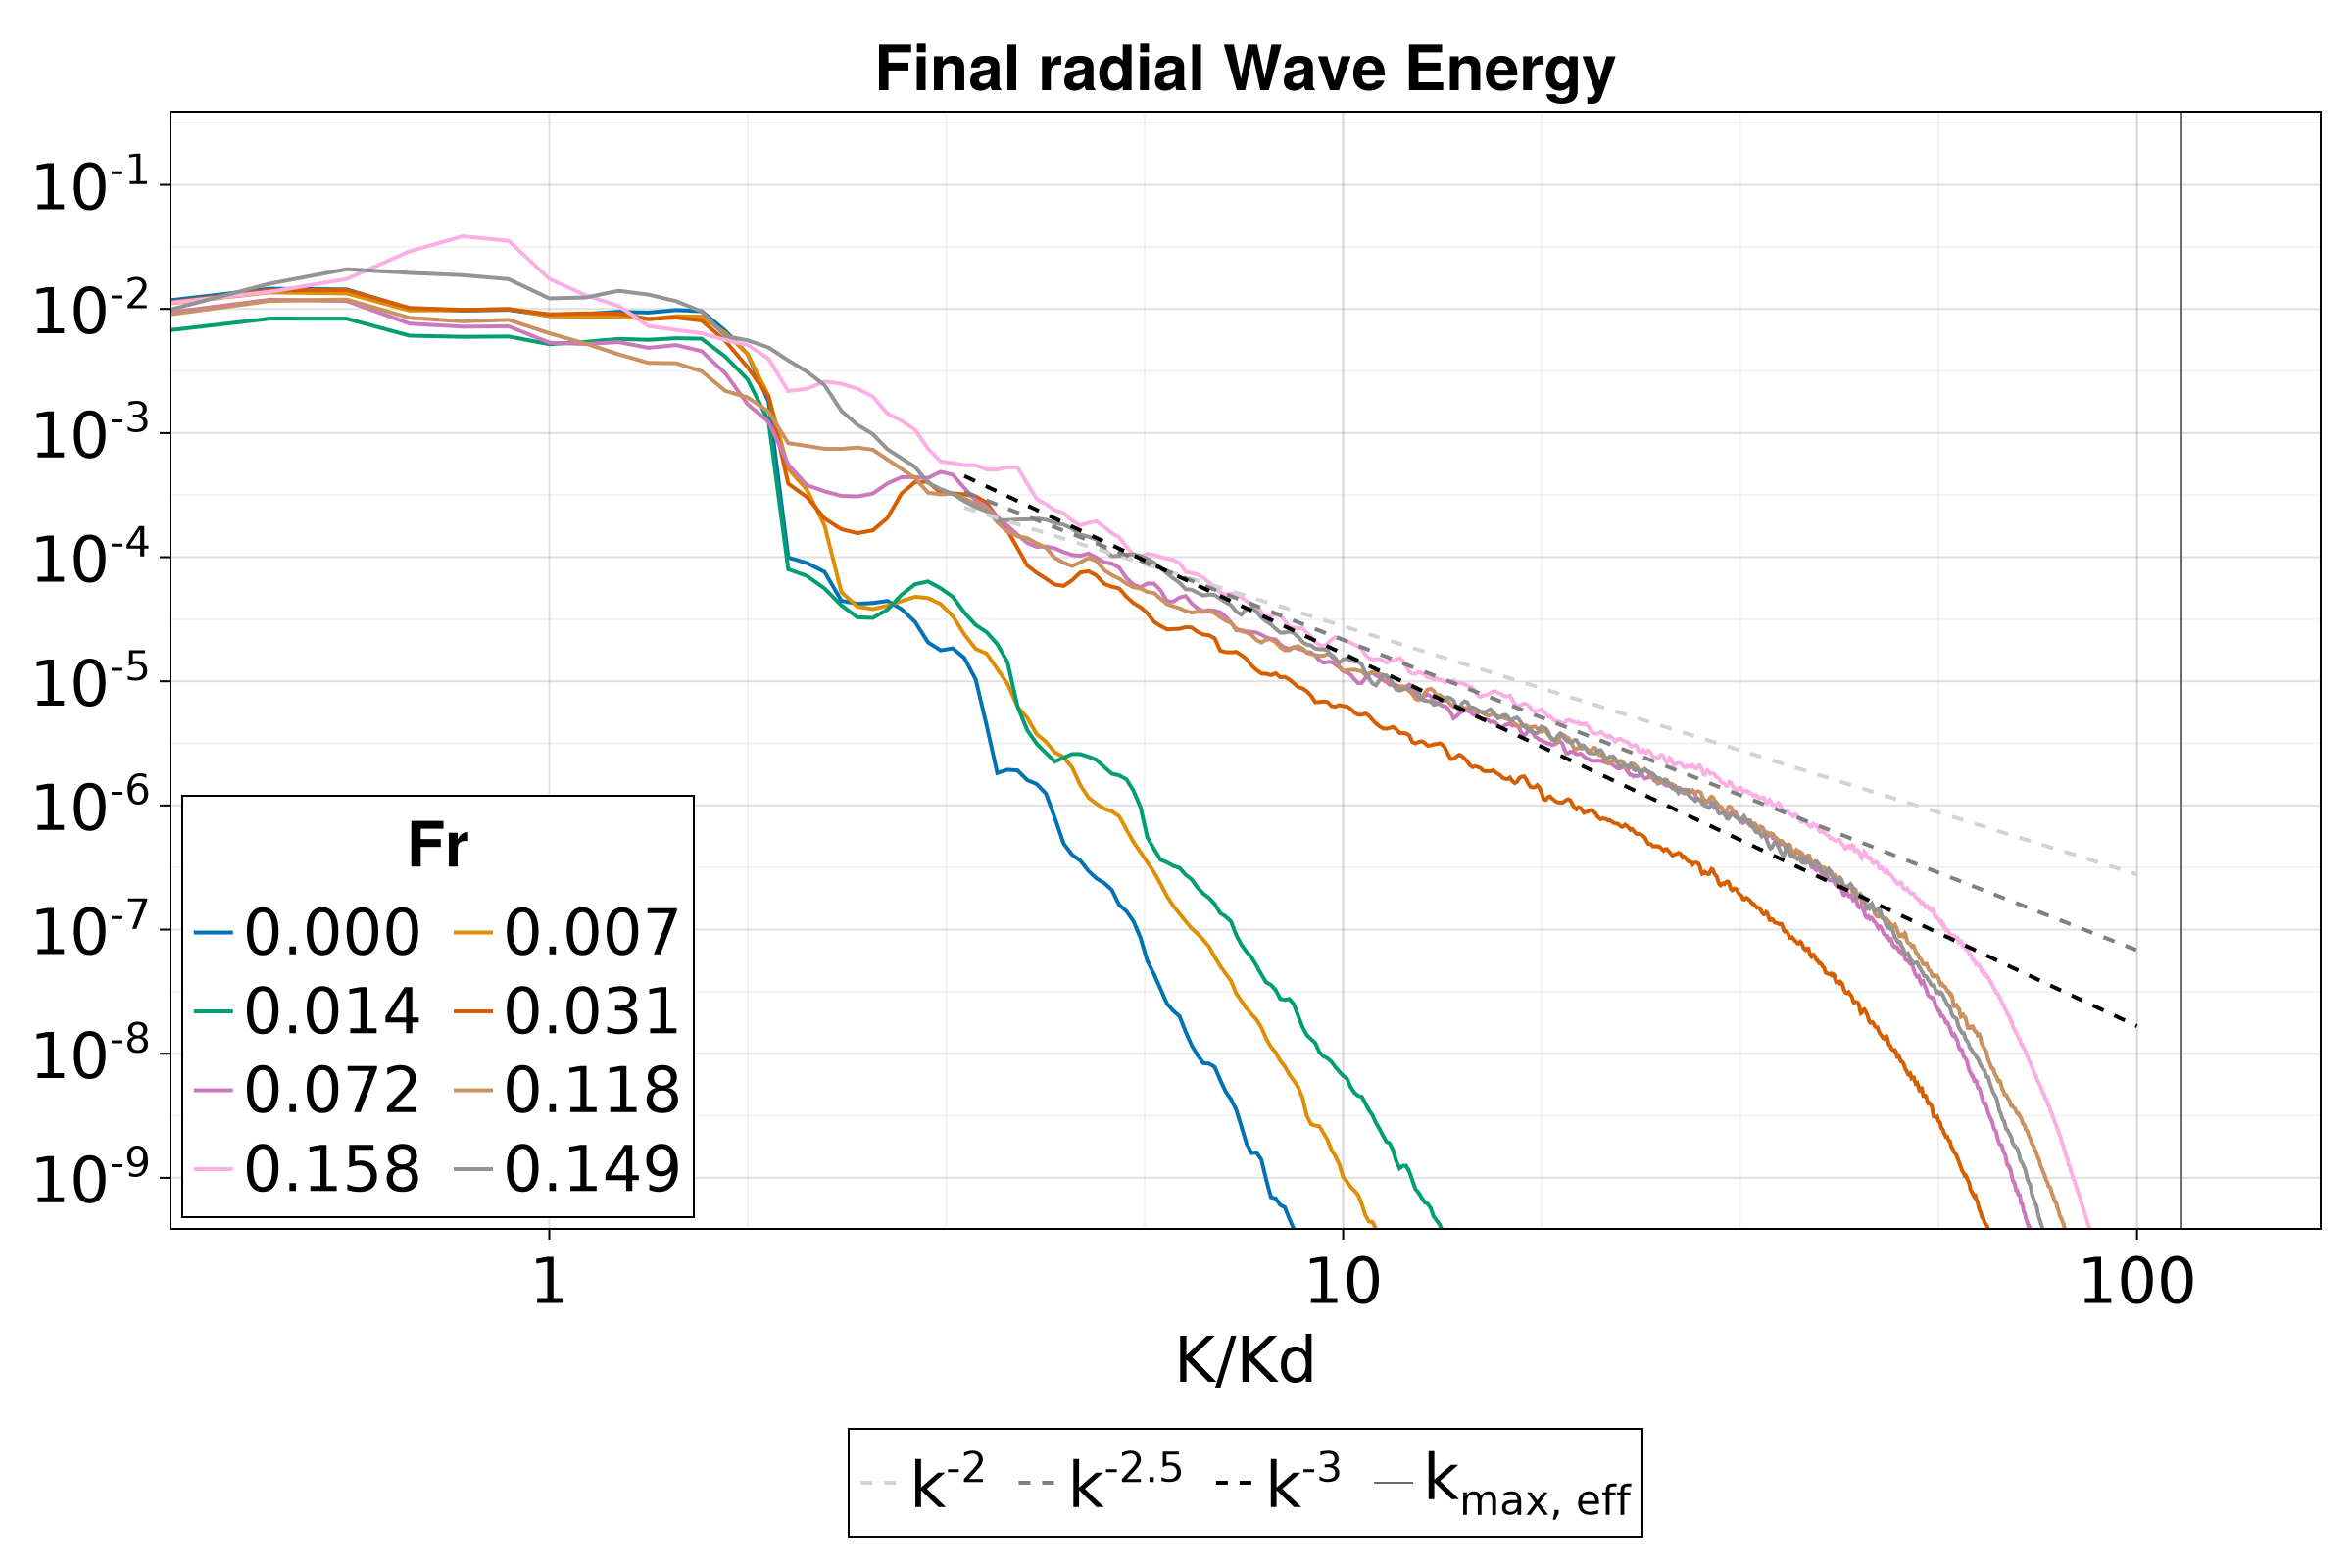

In [64]:
save("test_images/final_wave_energy.png", fin_e_energy_fig)
fin_e_energy_fig

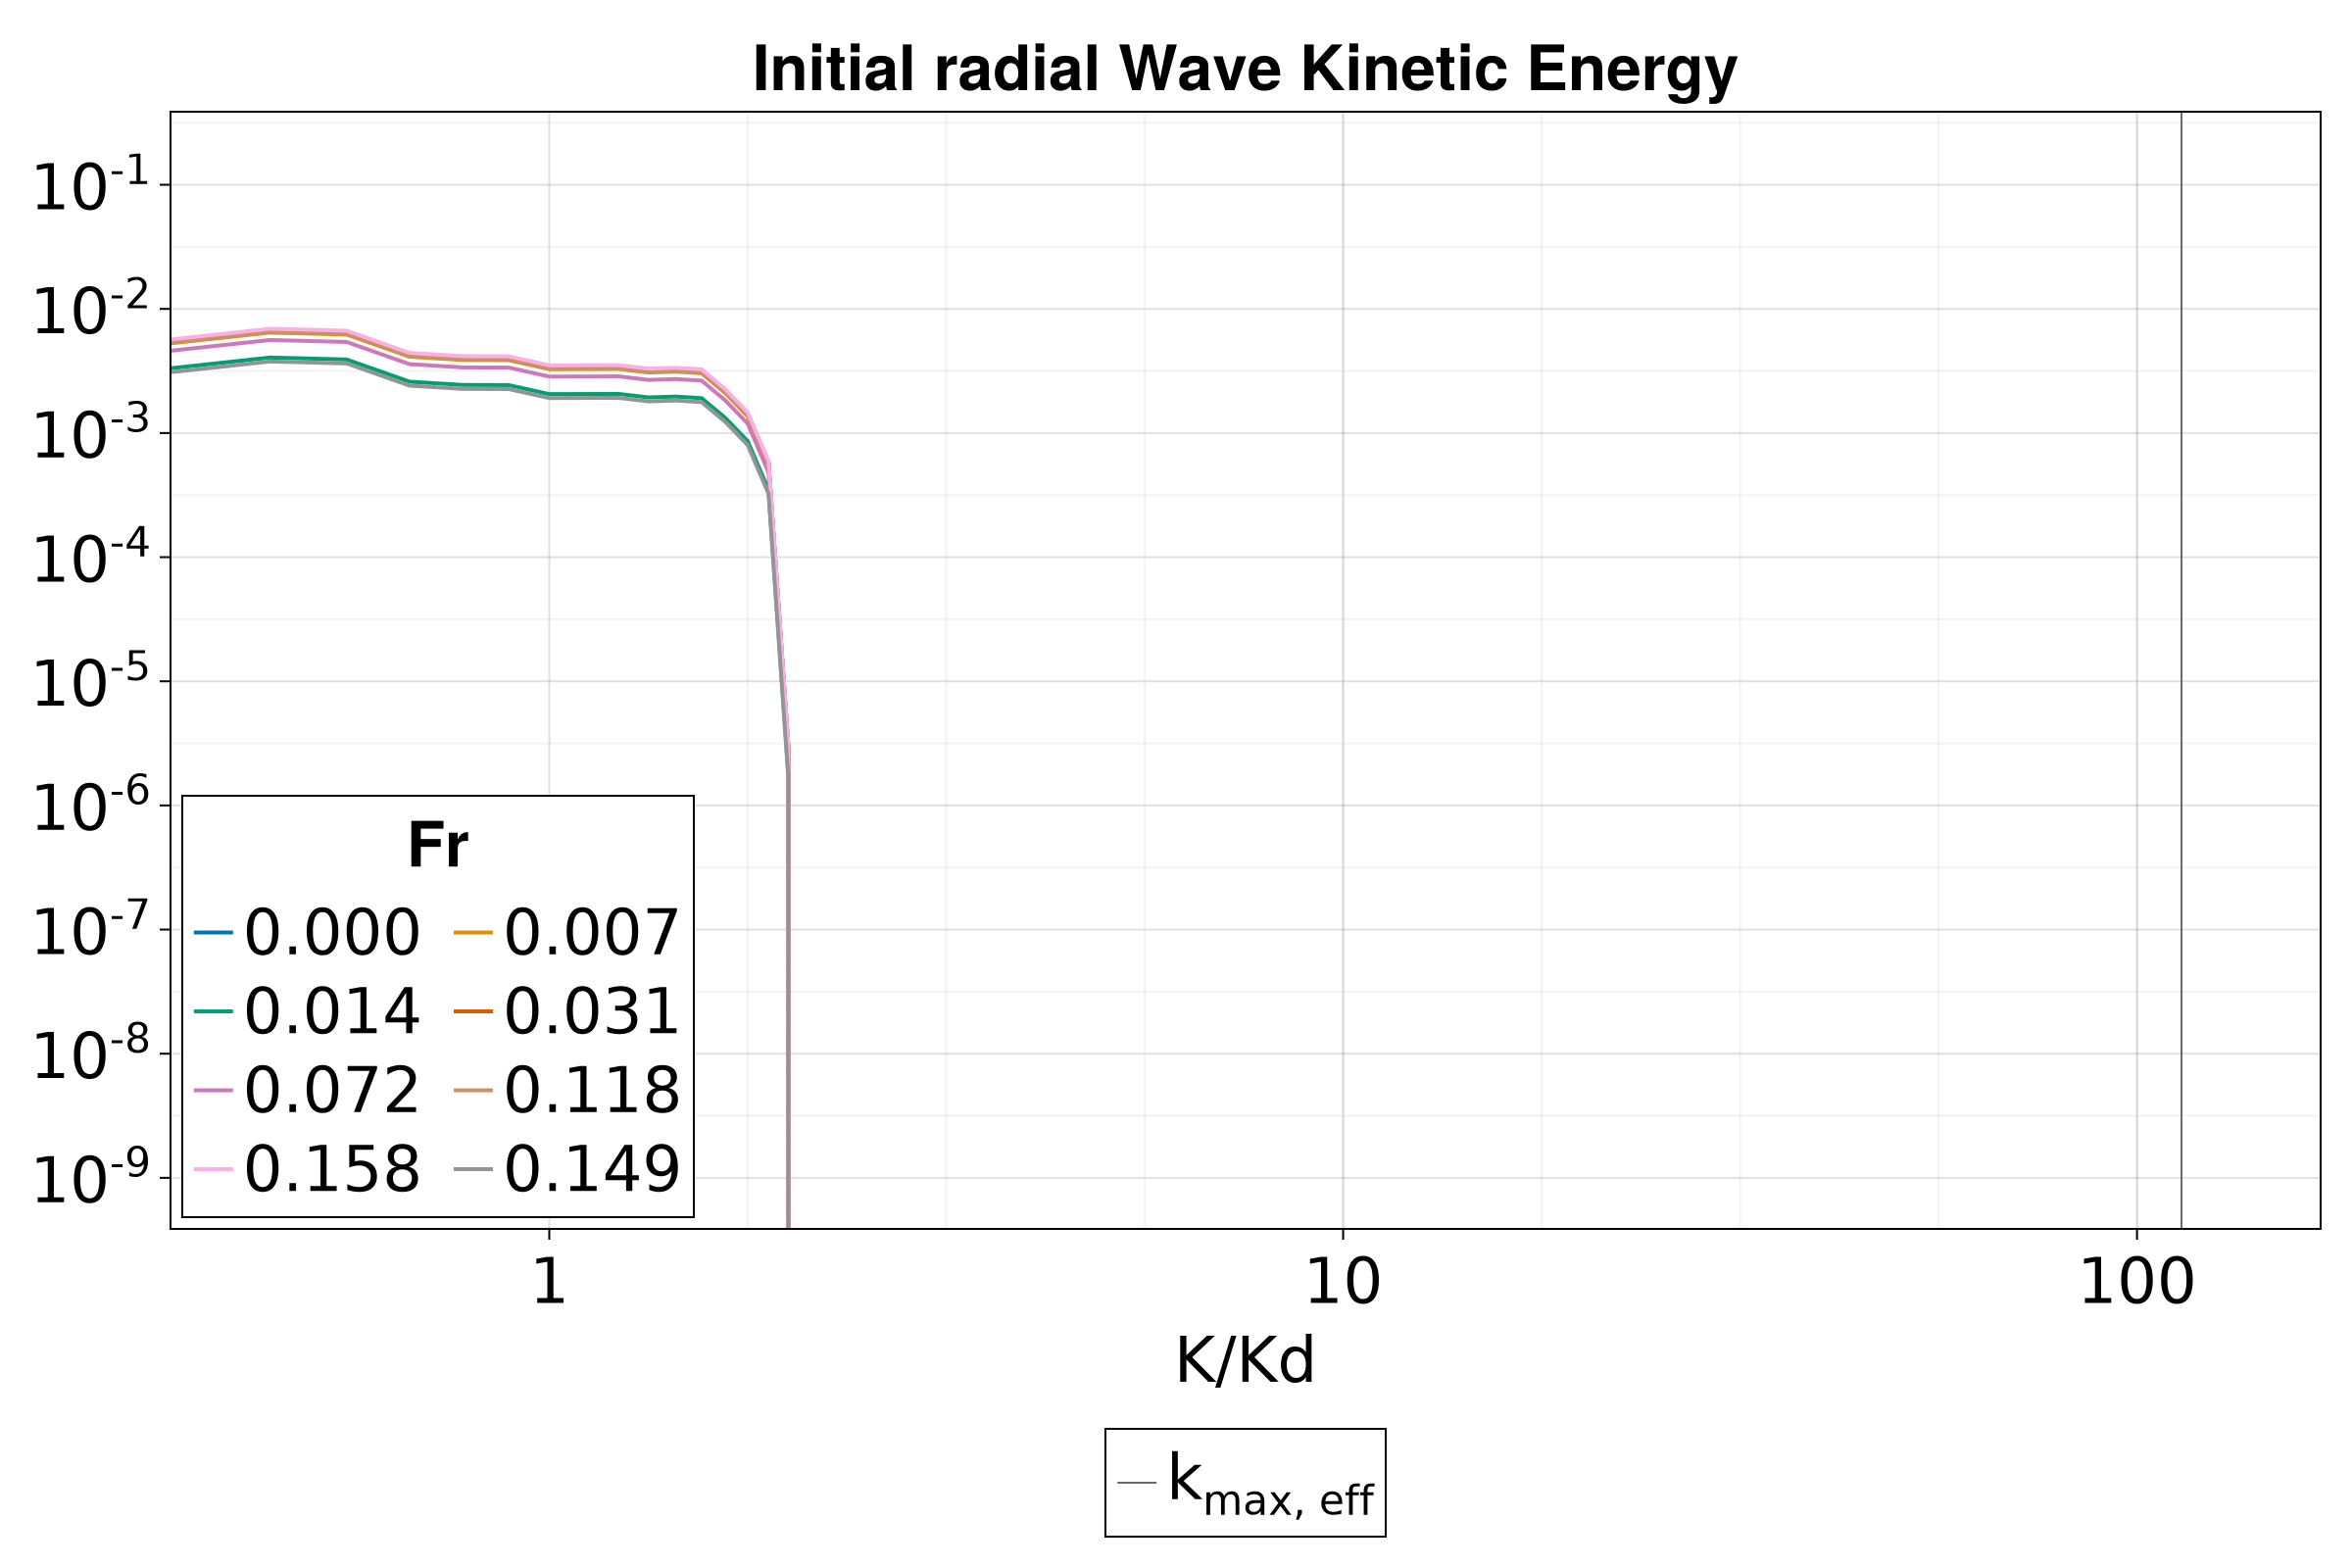

In [65]:
save("test_images/initial_wave_ke.png", ic_ke_energy_fig)
ic_ke_energy_fig

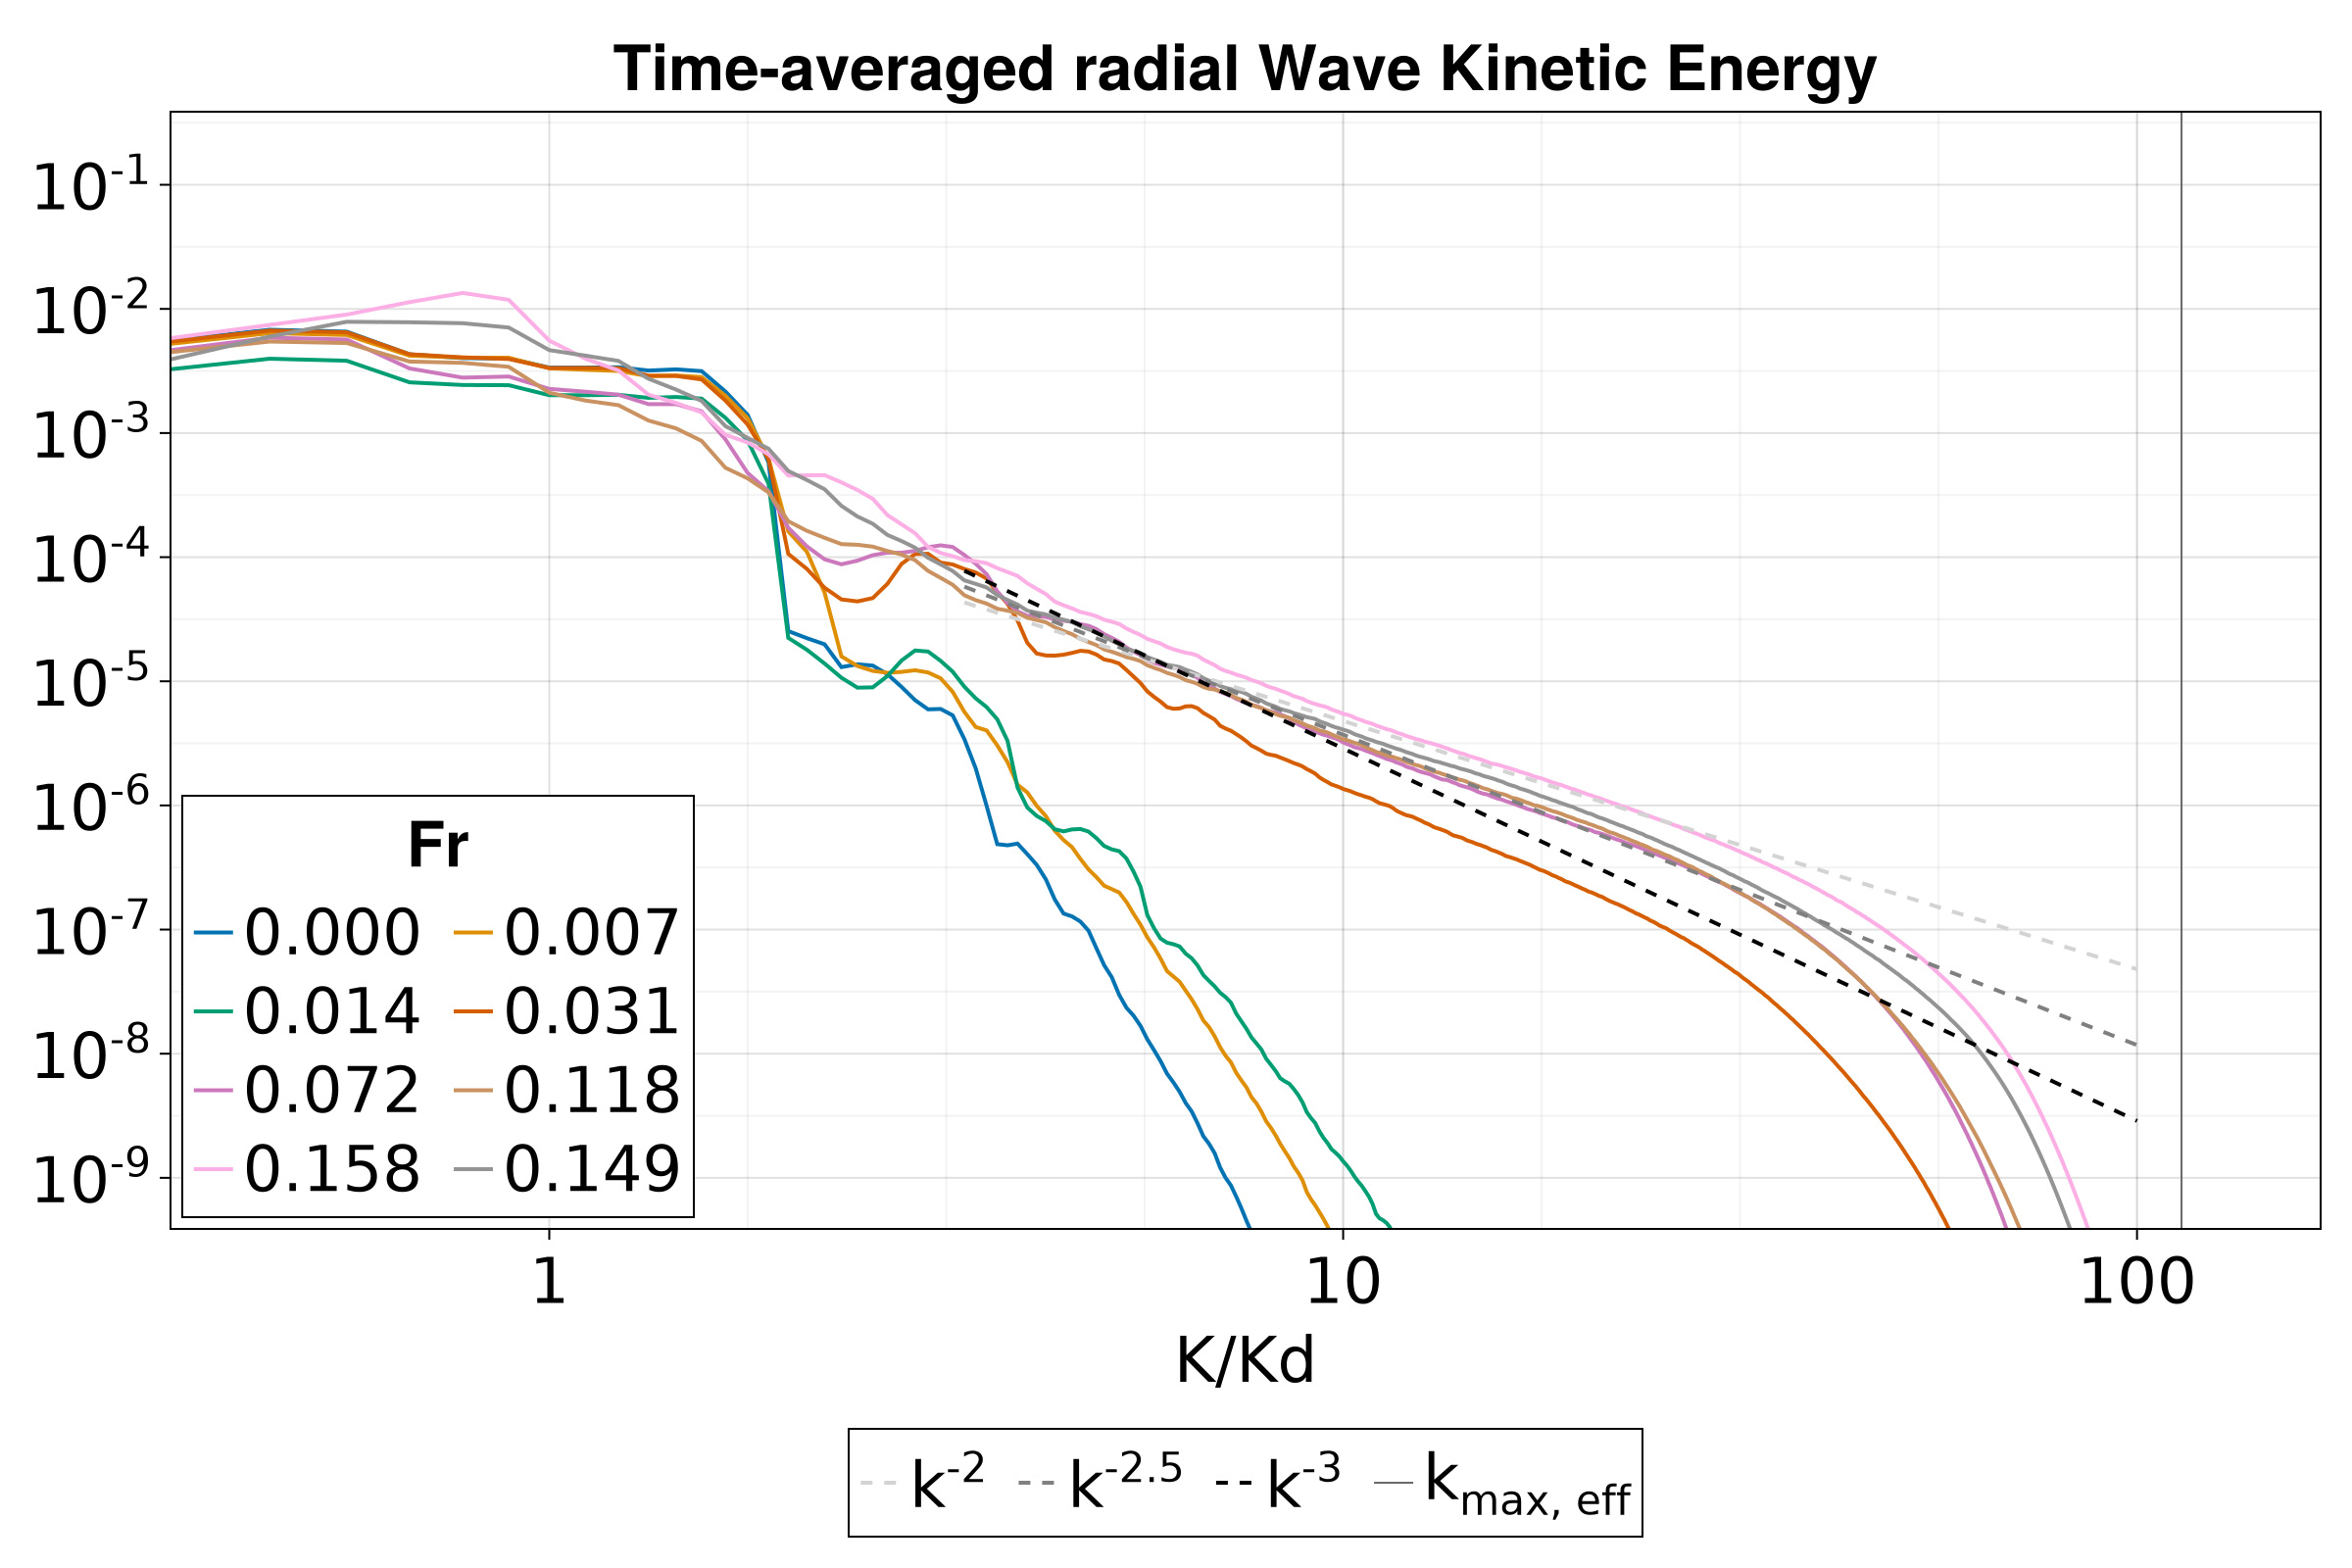

In [66]:
save("test_images/average_wave_ke.png", ave_ke_energy_fig)
ave_ke_energy_fig

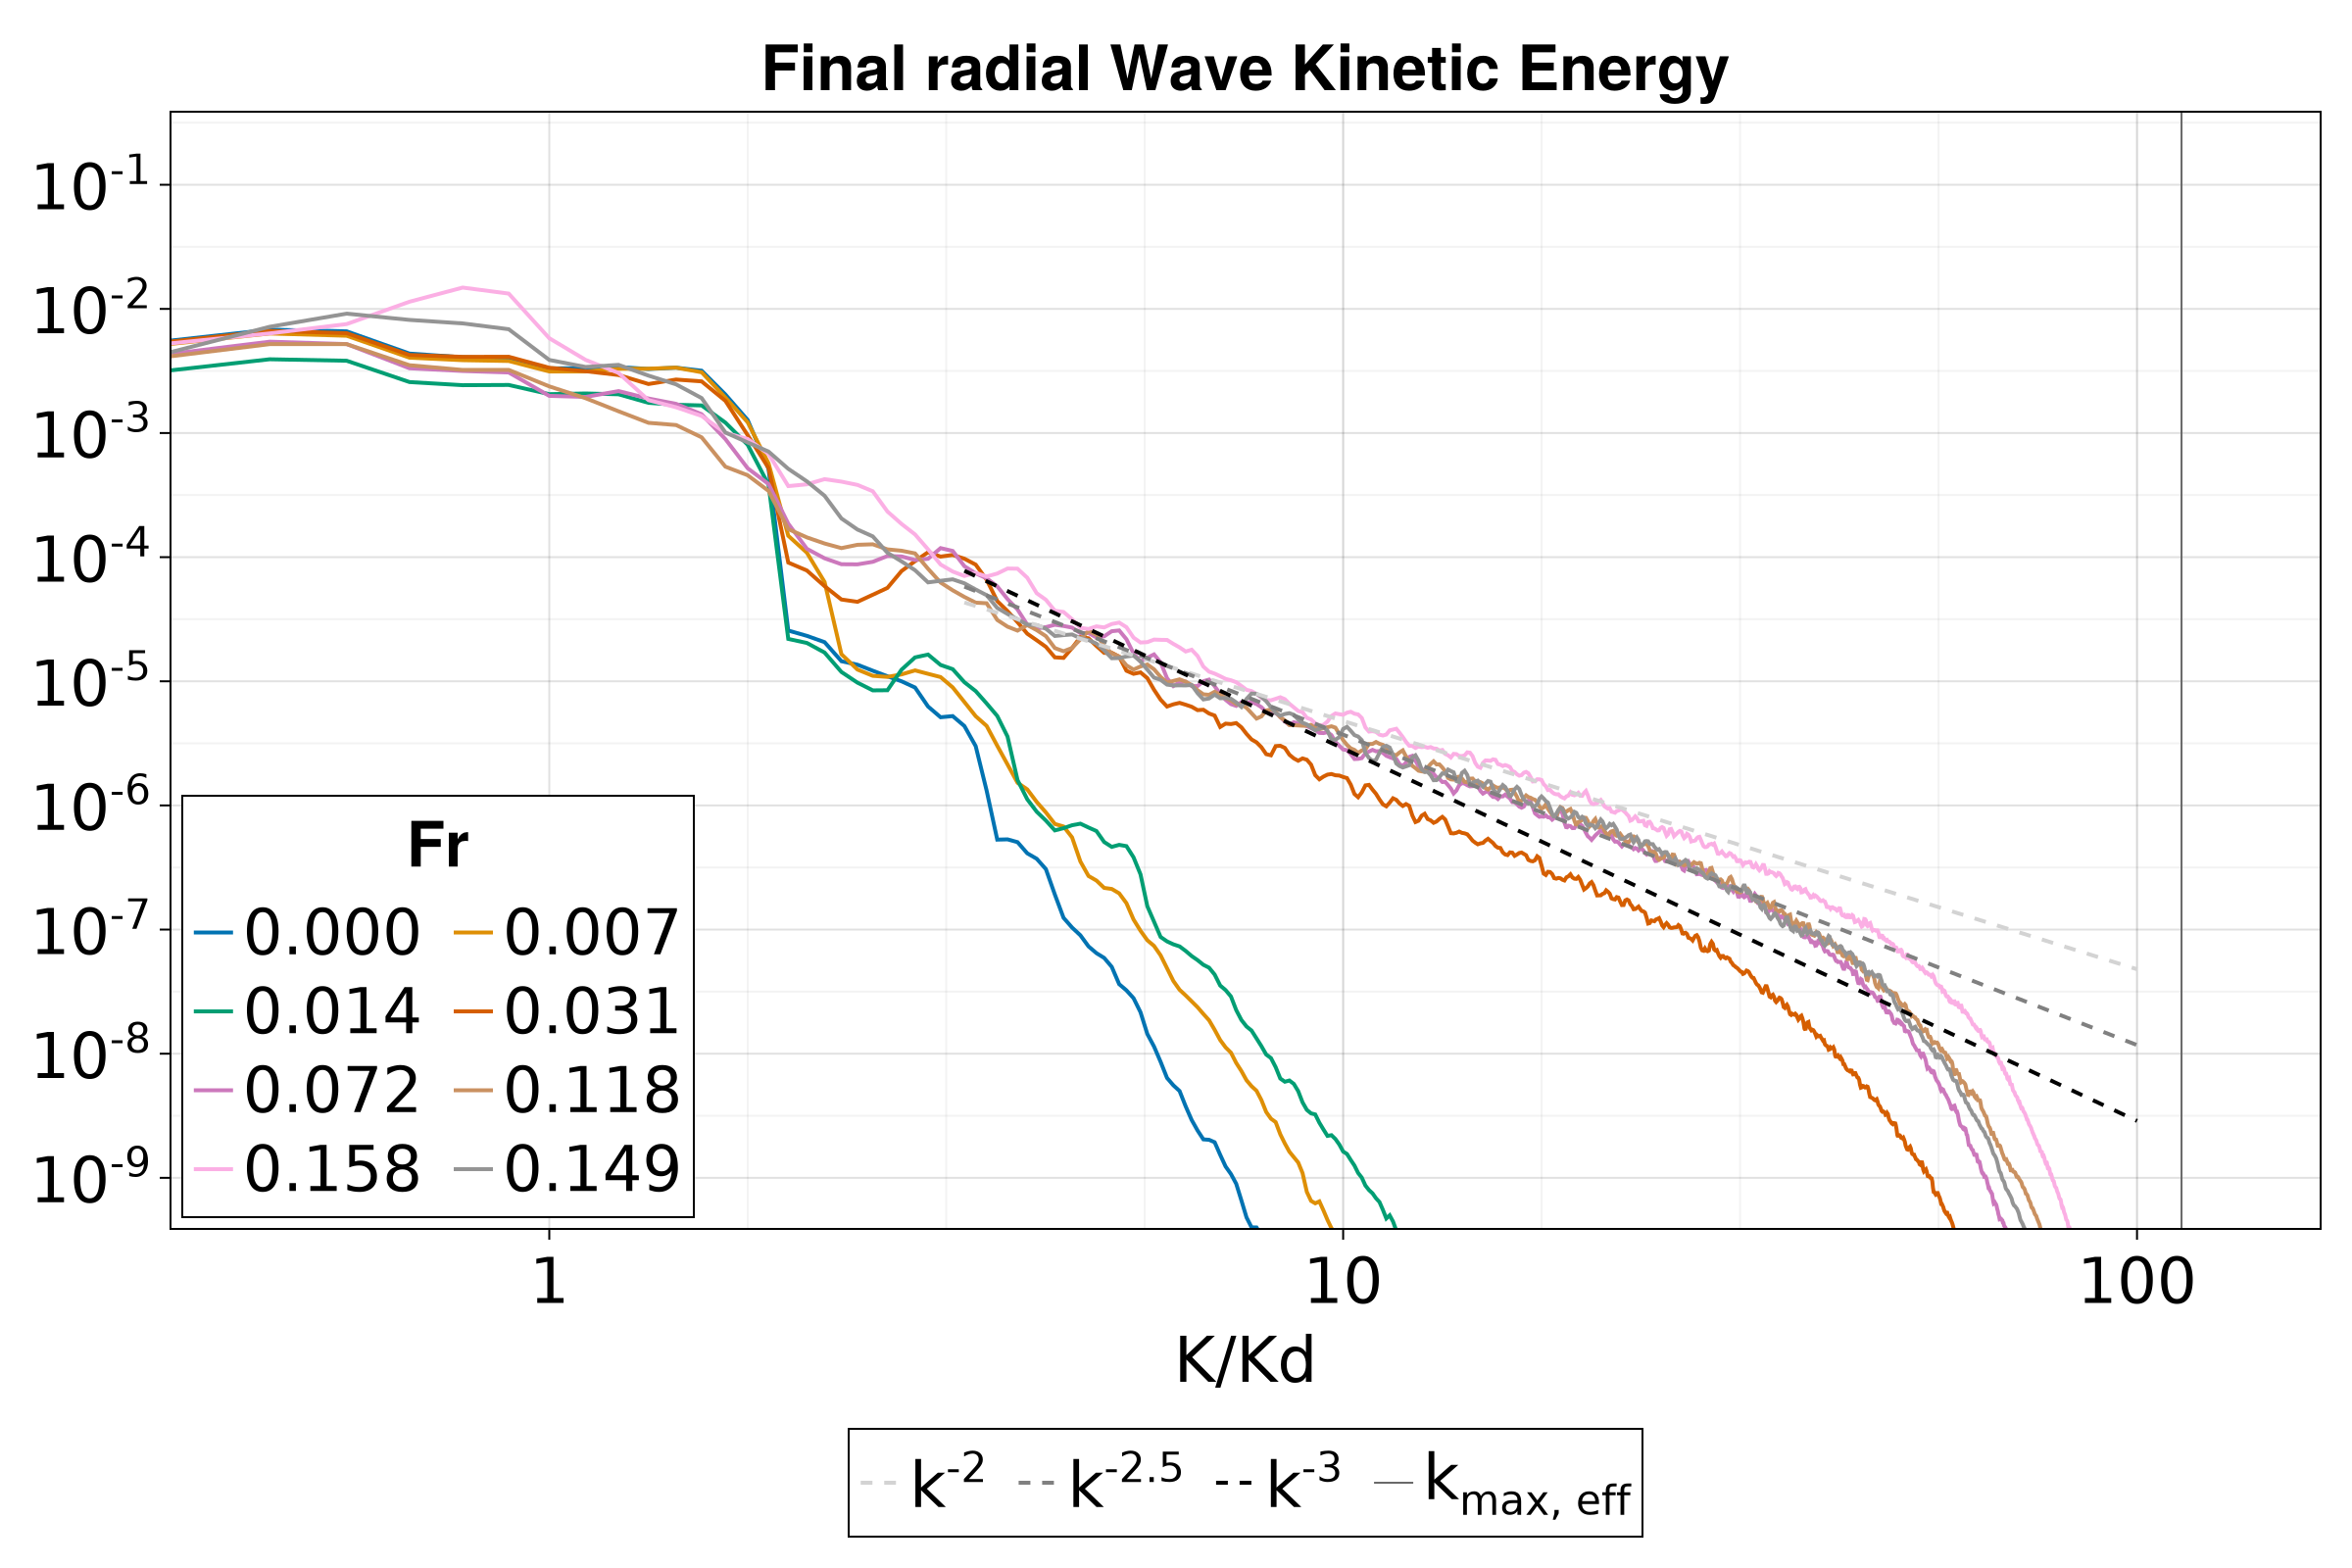

In [67]:
save("test_images/final_wave_ke.png", fin_ke_energy_fig)
fin_ke_energy_fig